In [1]:
# import sys
# sys.path.append('..')

In [2]:
from utility import load_dataset, load_model_with_ckpt, make_segments_and_graph
import draw_utils

/opt/miniconda3/envs/SPGIE/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import torch
import torchvision.transforms as VT

In [4]:
import os
from PIL import Image
import numpy as np

import sys
sys.path.append('..')
print(sys.path)
from cnn_dataset.mnistm import MNISTM

DATA_DIR = '~/data/'
ORIGIN_DATA_DIR = DATA_DIR + 'mnist_m/'
ori_dataset = MNISTM(ORIGIN_DATA_DIR, mode='test')

dataset = load_dataset('mnist_m', train=False)

['/home/dragonchen/SPGIE_thesis/explainer', '/opt/miniconda3/envs/SPGIE/lib/python310.zip', '/opt/miniconda3/envs/SPGIE/lib/python3.10', '/opt/miniconda3/envs/SPGIE/lib/python3.10/lib-dynload', '', '/opt/miniconda3/envs/SPGIE/lib/python3.10/site-packages', '..', '..']
----- Loading test dataset -----


In [5]:
# hidden_dim = 20
# ckpt_name = '/home/dragonchen/mlruns/0/c02d833566014cb0877882980a24f7f7/artifacts/best.pt'
hidden_dim = 64
ckpt_name = '/home/dragonchen/mlruns/0/b6c409724cbc4c6da8f703344d56dc58/artifacts/best.pt'
# hidden_dim = 128
# ckpt_name = '/home/dragonchen/mlruns/0/843a07bea5794a3787f90b9356395c43/artifacts/best.pt'
# hidden_dim = 256
# ckpt_name = '/home/dragonchen/mlruns/0/e367774683fa4f3e9e69e439b7aaf318/artifacts/best.pt'

aggr = 'add'
pool = 'max'

device = torch.device('cpu')
model = load_model_with_ckpt(
    input_dim=dataset.num_features,
    hidden_dim=hidden_dim,
    output_dim=dataset.num_classes,
    drn_k=4, aggr=aggr, pool=pool,
    device=device,
    ckpt_name=ckpt_name,
)

Pooling with max
Using self-loops
There are 2 aggregation layers


In [6]:
# !nvidia-htop.py

In [7]:
evaluate_on_testset = False

if evaluate_on_testset:
    import sys
    sys.path.append('..')
    from models.graph_phase import test
    from torch_geometric.loader import DataLoader

    # test_dev = torch.device('cuda:0')
    test_dev = torch.device('cpu')
    loader = DataLoader(dataset, batch_size=128, shuffle=False)
    acc, _ = test(model.to(test_dev), loader, device=test_dev, mlflow_log=False)
    print(f'Got {acc * 100:.2f}% acc on testing set.')
    model = model.to(device)

In [50]:
img_idx = 22
img_ori, lbl = ori_dataset[img_idx]
# img_ori, lbl = MNISTM(ORIGIN_DATA_DIR, mode='train')[img_idx]
img_sp, segments, node2map = make_segments_and_graph(
    torch.permute(img_ori, (1, 2, 0)), channel_axis=2,
)
img_sp.y = torch.tensor(lbl)

In [51]:
# temp = dataset[0]
# temp = img_sp
# print(temp.x.dtype)
# print(temp.edge_index.dtype)
# print(temp.y.dtype)
# print(temp.pos.dtype)

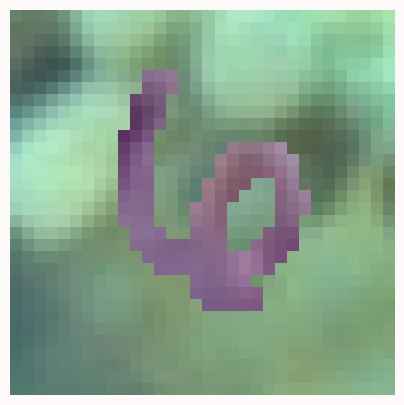

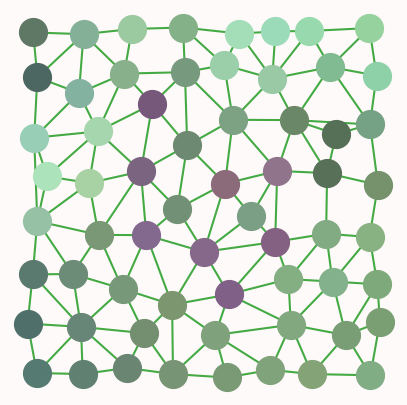

In [52]:
import matplotlib.pyplot as plt

# original
draw_utils.show_original(img_ori)

# superpixel version
draw_utils.draw_superpixel_from_graph(
    img_sp.pos, img_sp.x[:, 2:],
    img_sp.edge_index,
)
plt.show()

In [53]:
# img_temp = img_ori.clone()

# graph_size = img_sp.x.shape[0]

# for node_idx in range(graph_size):
#     m = node2map[node_idx]
#     img_temp[:, m] = img_temp[:, m] * 0.7
#     img_temp[0, m] = node_idx / graph_size

# draw_utils.show_original(img_temp)

# x_temp = img_sp.x.clone()
# for node_idx in range(graph_size):
#     x_temp[node_idx, 2] = node_idx / graph_size * 255

# # superpixel version
# draw_utils.draw_superpixel_from_graph(
#     img_sp.pos, x_temp[:, 2:],
#     img_sp.edge_index,
# )
# plt.show()

In [54]:
img_sp.batch = torch.zeros(img_sp.x.shape[0]).long()
img_sp = img_sp.to(device)

out = model(img_sp).detach().cpu()

print('true', lbl)
print('pred', out.argmax(1).item())

true 6
pred 6


In [55]:
# torch.manual_seed(1340)
for i, c in enumerate(torch.softmax(out, 1).tolist()[0]):
    print(f'{i} {c:.04f}')

0 0.0000
1 0.0000
2 0.0002
3 0.0000
4 0.0009
5 0.0012
6 0.9802
7 0.0000
8 0.0173
9 0.0000


## Start Explaining

In [56]:
from PIL import Image
plt.rcParams['figure.facecolor'] = '#fffafa'
import networkx as nx
from skimage.segmentation import slic, mark_boundaries

In [57]:
from models.jit_drn_model import (
    knn_graph, to_undirected, normalized_cut_2d,
    graclus_cluster,
#     aggr_pool, aggr_pool_x,
    global_pool_aggr
)

In [58]:
from torch_scatter import scatter
from torch_geometric.typing import OptTensor, Optional, Tuple
from torch import Tensor
from torch_geometric.nn.pool.consecutive import consecutive_cluster
from torch_geometric.nn.pool.pool import pool_batch

def _aggr_pool_x(cluster, x, aggr: str, size: Optional[int] = None):
    """Call into scatter with configurable reduction op"""
    return scatter(x, cluster, dim=0, dim_size=size, reduce=aggr)

def global_pool_aggr(x, batch: OptTensor, aggr: str, size: Optional[int] = None):
    """Global pool via passed aggregator: 'mean', 'add', 'max'"""
    if batch is None and size is None:
        raise Exception('Must provide at least one of "batch" or "size"')
    if batch is not None:
        size = int(batch.max().item() + 1)
    assert batch is not None
    return scatter(x, batch, dim=0, dim_size=size, reduce=aggr)

# this function is specialized compared to the more general non-jittable version
# in particular edge_attr can be removed since it is always None
def aggr_pool(cluster, x, batch: OptTensor, aggr: str) -> Tuple[Tensor, OptTensor]:
    """jit-friendly version of max/mean/add pool"""
    global node_hist
    print('c1', cluster.shape)
    print(cluster[:20])
    c1 = cluster.detach().cpu()
    cluster, perm = consecutive_cluster(cluster)
    print('c2', cluster.shape)
    print(cluster[:20])
    print('perm', perm.shape)
    print('perm', perm[:10])
    c2 = cluster.detach().cpu()
    p = perm.detach().cpu()
    node_hist.append({
        'c1': c1,
        'c2': c2,
        'p': p
    })

    x = _aggr_pool_x(cluster, x, aggr)
    if batch is not None:
        batch = pool_batch(perm, batch)
    return x, batch

def aggr_pool_x(cluster, x, batch: OptTensor, aggr: str, size: Optional[int] = None) -> Tuple[Tensor, OptTensor]:
    """*_pool_x with configurable aggr method"""
    global node_hist
    if batch is None and size is None:
        raise Exception('Must provide at least one of "batch" or "size"')
    if size is not None and batch is not None:
        batch_size = int(batch.max().item()) + 1
        return _aggr_pool_x(cluster, x, aggr, batch_size * size), None

#     print('c1', cluster.shape)
    print(cluster)
    c1 = cluster.detach().cpu()
    cluster, perm = consecutive_cluster(cluster)
#     print('c2', cluster.shape)
    print(cluster)
#     print('perm', perm.shape)
#     print('perm', perm)
    c2 = cluster.detach().cpu()
    p = perm.detach().cpu()
    node_hist.append({
        'c1': c1,
        'c2': c2,
        'p': p
    })
    
    x = _aggr_pool_x(cluster, x, aggr)
    if batch is not None:
        batch = pool_batch(perm, batch)

    return x, batch

c1 torch.Size([63])
tensor([ 0,  0,  2,  3,  4,  5,  6,  6,  3,  9, 10, 11,  9,  4, 10, 11, 16, 17,
        18, 19])
c2 torch.Size([63])
tensor([ 0,  0,  1,  2,  3,  4,  5,  5,  2,  6,  7,  8,  6,  3,  7,  8,  9, 10,
        11, 12])
perm torch.Size([33])
perm tensor([ 1,  2,  8, 13,  5,  7, 12, 14, 15, 24])


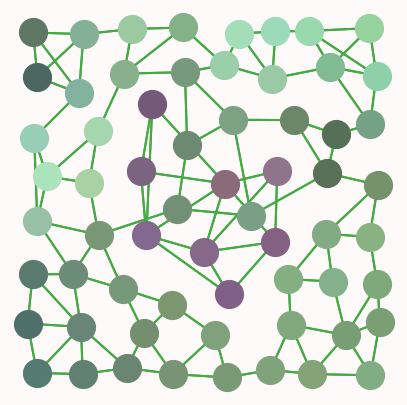

tensor([ 0,  0,  2,  3,  4,  3,  2,  4,  8,  9, 10, 11, 11, 13, 13,  9, 16, 10,
        18, 19, 19, 16, 22, 22, 24, 25, 18, 27, 28, 24, 27, 28, 25])
tensor([ 0,  0,  1,  2,  3,  2,  1,  3,  4,  5,  6,  7,  7,  8,  8,  5,  9,  6,
        10, 11, 11,  9, 12, 12, 13, 14, 10, 15, 16, 13, 15, 16, 14])


[[-11.108418464660645,
  -7.020353317260742,
  -5.164852142333984,
  -9.986882209777832,
  -3.386016368865967,
  -6.957969665527344,
  -0.07067548483610153,
  -12.306979179382324,
  -3.6206398010253906,
  -12.675392150878906]]

In [59]:
import torch.nn.functional as F

torch.manual_seed(100)

drn = model.drn # get the model layer
x = img_sp.x
batch = img_sp.batch

# draw_superpixel_from_graph(x, gd.edge_index)

x = drn.datanorm * x
x = drn.inputnet(x)

nAgg = len(drn.agg_layers)

node_hist = []
# print(f'start x', x.shape)
node_hist.append({'x': x.detach().cpu()})
for i, edgeconv in enumerate(drn.agg_layers):
    knn = knn_graph(x, drn.k, batch, loop=drn.loop, flow=edgeconv.flow)
#     print(f'i {i} knn', knn.shape)
    edge_index = to_undirected(knn)
#     print(x.T)
#     plot_x(x)
    x = edgeconv(x, edge_index)
#     print(x.T)
#     plot_x(x)
    
#     print(f'i {i} edge conv', x.shape)

    weight = normalized_cut_2d(edge_index, x)
    cluster = graclus_cluster(edge_index[0], edge_index[1], weight, x.size(0))
#     print(f'i {i} cluster', cluster.shape)

    if i == nAgg - 1:
        x, batch = aggr_pool_x(cluster, x, batch, drn.aggr_type)
    else:
        x, batch = aggr_pool(cluster, x, batch, drn.aggr_type)
    
    # extract history node
#     hist = cluster.tolist()
# #     print('h', hist)
#     node_hist.append(torch.tensor(hist))
    xx = img_sp.x.cpu()
    ee = edge_index.cpu()
#     print('h', hist)
#     print('ee', ee)
    node_hist.append({'x': x.detach().cpu()})
    
    if i == 0:
        draw_utils.draw_superpixel_from_graph(
            xx[:, :2] / 255, xx[:, 2:], ee
        )


# print('b', batch)
x = global_pool_aggr(x, batch, drn.aggr_type)
# print('global x', x)
node_hist.append({'global_x': x.detach().cpu()})

# print(f'global x', x.shape)

out = drn.output(x).squeeze(-1)
out = F.log_softmax(out, dim=1)
out.tolist()

In [60]:
drn.output(node_hist[-1]['global_x'])

tensor([[-3.4710,  0.6170,  2.4725, -2.3495,  4.2514,  0.6794,  7.5667, -4.6696,
          4.0168, -5.0380]], grad_fn=<AddmmBackward0>)

In [61]:
# print([n.keys() for n in node_hist])
# for n in node_hist:
#     print('-----layer-----')
#     for k in n:
#         print(k, n[k].shape)

In [62]:
# from global x to layer2
from collections import defaultdict
counter = defaultdict(int)
basenode_values = defaultdict(list)
xx2 = node_hist[-2]['x']

gx = node_hist[-1]['global_x'].squeeze()
for i, g in enumerate(gx.tolist()):
    if g > 0:
        xx2k = xx2[:, i].tolist().index(g)
        counter[xx2k] += 1
        basenode_values[xx2k].append(g)
# print('counter', counter)
# print('basenode_imp', basenode_values)

basenode_imp = {}
for k, v in basenode_values.items():
    print('k', k, end=' ')
    avg = sum(v) / len(v)
    print('avg', avg)
    basenode_imp[k] = avg

k 6 avg 9.24962035814921
k 9 avg 9.609306156635284
k 5 avg 17.57404192135884
k 1 avg 0.12173938751220703


In [63]:
# pick those nodes be refered multiple times
l1 = node_hist[1]
l2 = node_hist[3]

final_nodes = [n for n in counter if counter[n] >= 1] # there !
final_nodes

[6, 9, 5, 1]

In [64]:
# base on nodes do softmax on basenode_imp
temp_keys = [k for k in basenode_imp if k in final_nodes]
print('keys', temp_keys)
temp_values = [v for k, v in basenode_imp.items() if k in final_nodes]
print('values', temp_values)

x = temp_values

# # softmax
# temp_values = torch.softmax(torch.tensor(x), dim=0).tolist()
# print('new', temp_values)

# min-max
min_v = np.min(x)
max_v = np.max(x)
temp_values = (x - min_v) / (max_v - min_v)
print('new', temp_values)

# put it back
basenode_imp = dict(zip(temp_keys, temp_values))

keys [6, 9, 5, 1]
values [9.24962035814921, 9.609306156635284, 17.57404192135884, 0.12173938751220703]
new [0.52301872 0.54362837 1.         0.        ]


In [65]:
basenode_track = {} # record basenode mapping

nodes_l2 = []
for n in final_nodes:
    idx = l2['p'][n].item() # put node-num get cluster idx
#     print(idx)
    c = l2['c2'][idx].item() # extract original node-num from cluster idx
#     print('c', c)
    nodes = torch.arange(len(l2['c2']))[l2['c2'] == c].tolist()
#     print('nodes', nodes)
    
    for cn in nodes: # child node
        basenode_track[cn] = c
    
    nodes_l2 += nodes
nodes_l2

[10, 17, 16, 21, 9, 15, 2, 6]

In [66]:
temp_track = {}

nodes_l1 = []
for n in nodes_l2:
    idx = l1['p'][n].item() # put node-num get cluster idx
#     print(idx)
    c = l1['c2'][idx].item() # extract original node-num from cluster idx
#     print('c', c)
    nodes = torch.arange(len(l1['c2']))[l1['c2'] == c].tolist()
#     print('nodes', nodes)
    
    for cn in nodes: # child node
        temp_track[cn] = basenode_track[c] # extrac parent's basenode into child node
    
    nodes_l1 += nodes
basenode_track = temp_track
nodes_l1

[17, 33, 27, 37, 26, 36, 39, 47, 16, 24, 22, 32, 3, 8, 9, 12]

## Draw

In [67]:
import random
color_set = {
    v: [random.randint(0, 255) for _ in range(3)]
    for _, v in basenode_track.items()
}

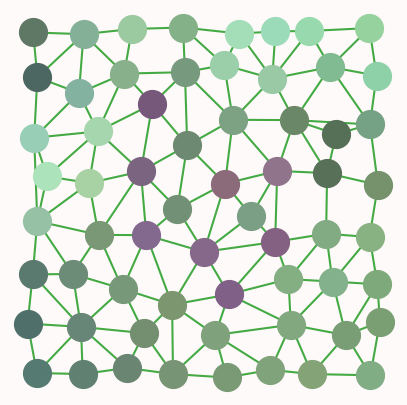

1

In [68]:
# use old function print
import numpy as np
pos = img_sp.x[:, :2].cpu().numpy()
# pos = np.flip(pos, 1)
rgb = img_sp.x[:, 2:].cpu().numpy()
draw_utils.draw_superpixel_from_graph(
    pos, rgb, img_sp.edge_index,
)
1

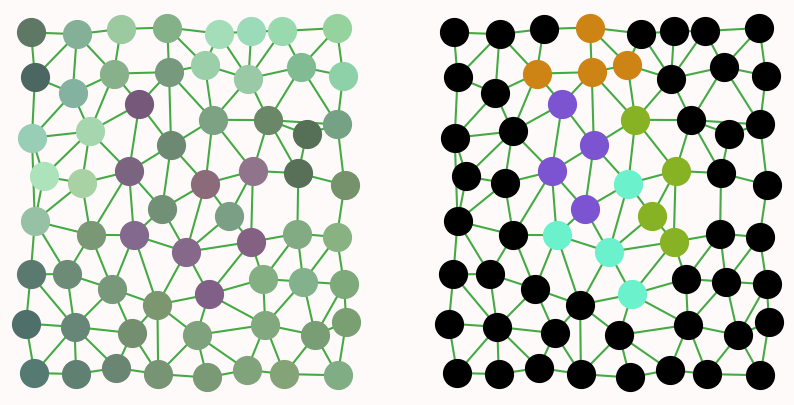

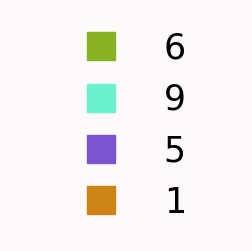

In [69]:
# old function print original, forus and basenode highlight
img = img_sp
pos = img.x[:, :2].cpu().numpy()
rgb = img.x[:, 2:].cpu().numpy()

# # single colour
# imp = [[0, 0, 0] for _ in range(rgb.shape[0])]
# for n in nodes_l1:
#     imp[n][1] = 150

# basenode track
imp = [[0, 0, 0] for _ in range(rgb.shape[0])]
for n in nodes_l1:
    imp[n] = color_set[basenode_track[n]]

draw_utils.draw_superpixel_from_graph(
    pos, [rgb, imp], img.edge_index, multi_graph=True,
)

# color_set
plt.figure(figsize=(3, 3))
colors = ['#{:02x}{:02x}{:02x}'.format(*c) for n, c in color_set.items()]
f = lambda m,c: plt.plot([],[],marker=m, markersize=20, color=c, ls="none")[0]
handles = [f("s", c) for c in colors]
labels = [n for n, _ in color_set.items()]
legend = plt.legend(
    handles, labels,
    loc='center', framealpha=1, frameon=False,
    fontsize=25,
)
plt.axis('off')
# plt.show()
plt.savefig('demo1.svg')

true 6
pred 6


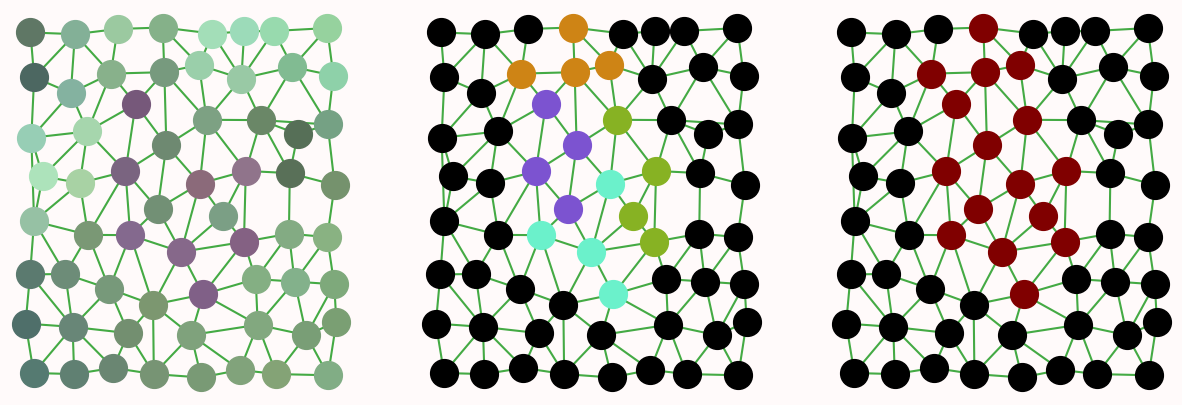

temp (3, 32, 32)


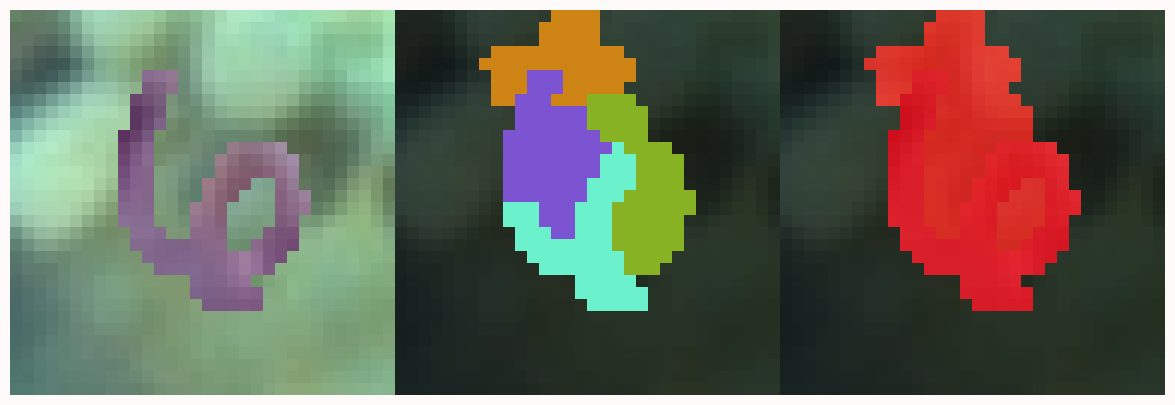

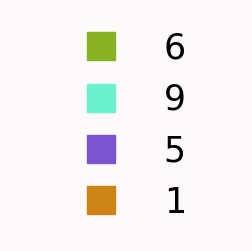

In [70]:
print('true', lbl)
print('pred', out.argmax(1).item())

# print rgb, basenode and imp
pos = img.x[:, :2].cpu().numpy()
rgb = img.x[:, 2:].cpu().numpy()

# # single colour
# imp = [[0, 0, 0] for _ in range(rgb.shape[0])]
# for n in nodes_l1:
#     imp[n][1] = 150

# basenode track
imp = [[0, 0, 0] for _ in range(rgb.shape[0])]
for n in nodes_l1:
    imp[n] = color_set[basenode_track[n]]

# basenode imp
imp2 = [[0, 0, 0] for _ in range(rgb.shape[0])]
for n in nodes_l1:
#     c = int(basenode_imp[basenode_track[n]] * 255)
#     imp2[n][1] = c
    imp2[n][0] = 128

draw_utils.draw_superpixel_from_graph(
    pos, [rgb, imp, imp2], img.edge_index, multi_graph=True,
)
# util.draw_superpixel_from_graph(pos, [rgb, imp2], img, multi_graph=True)


img_temp1 = img_ori.numpy().copy()
img_temp1 = img_temp1 * 0.3
img_temp2 = img_temp1.copy()

print('temp', img_temp1.shape)
for n in nodes_l1:
    m = node2map[n]
    
    replace_color = np.array(color_set[basenode_track[n]])
    replace_color = np.expand_dims(replace_color, axis=1)
    img_temp1[:, m] = replace_color / 255
    img_temp2[0, m] += 0.7

img_out = np.concatenate([img_ori, img_temp1, img_temp2], axis=2)
# img_out = np.concatenate([img_ori, img_temp2], axis=2)
# print('out', img_out.shape)
draw_utils.show_original(img_out, width=15)


# color_set
plt.figure(figsize=(3, 3))
colors = ['#{:02x}{:02x}{:02x}'.format(*c) for n, c in color_set.items()]
f = lambda m,c: plt.plot([],[],marker=m, markersize=20, color=c, ls="none")[0]
handles = [f("s", c) for c in colors]
labels = [n for n, _ in color_set.items()]
legend = plt.legend(
    handles, labels,
    loc='center', framealpha=1, frameon=False,
    fontsize=25,
)
plt.axis('off')
plt.show()